In [41]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,LabelEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import category_encoders as ce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [43]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sample = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

print(train.shape)
print(test.shape)
print(sample.head())

(750000, 18)
(250000, 17)
       id    y
0  750000  0.5
1  750001  0.5
2  750002  0.5
3  750003  0.5
4  750004  0.5


In [44]:
df=test

# **🔹1. Exploratory Data Analysis (EDA)**

In [45]:
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


In [47]:
print(f"shape = {df.shape}")
print(f"number of rows: {df.shape[0]}")
print(f"number of columns: {df.shape[1]}")

shape = (250000, 17)
number of rows: 250000
number of columns: 17


In [48]:
df.isna().sum().reset_index().rename(columns={'index':'column',0:'missing_values'}).sort_values(by='missing_values',ascending=False)

,column,missing_values
0,id,0
1,age,0
2,job,0
3,marital,0
4,education,0
5,default,0
6,balance,0
7,housing,0
8,loan,0
9,contact,0


In [49]:
print(f"number of duplicated rows: {df.duplicated().sum()}")

number of duplicated rows: 0


In [50]:
num_cols=df.select_dtypes(include=['int64','float64']).columns
cat_cols=df.select_dtypes(include=['object']).columns

In [51]:
def visual_categorical_plots(df, cat_cols):
    for col in cat_cols:
        counts = df[col].value_counts()
        n_unique = counts.shape[0]

        if n_unique <= 5:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            sns.countplot(x=df[col], palette="pastel", edgecolor="black", ax=axes[0])
            axes[0].set_title(f'Countplot of {col}')
            axes[0].tick_params(axis='x', rotation=45)
            counts.plot.pie(
                autopct='%1.1f%%',
                startangle=90,
                colors=sns.color_palette("Set3"),
                ax=axes[1]
            )
            axes[1].set_ylabel("")
            axes[1].set_title(f'Pie chart of {col}')
            axes[1].axis("equal")
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 4))
            sns.countplot(x=df[col], palette="Set2", edgecolor="black")
            plt.title(f'Countplot of {col} (many categories)')
            plt.tight_layout()
            plt.show()

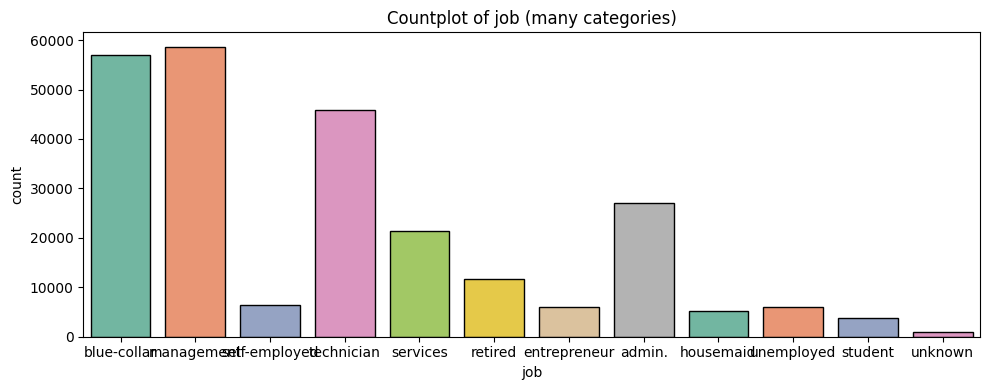

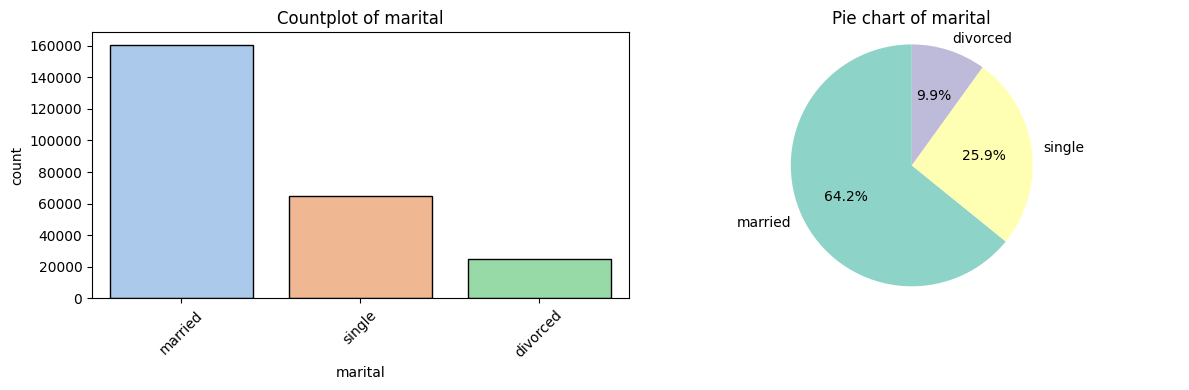

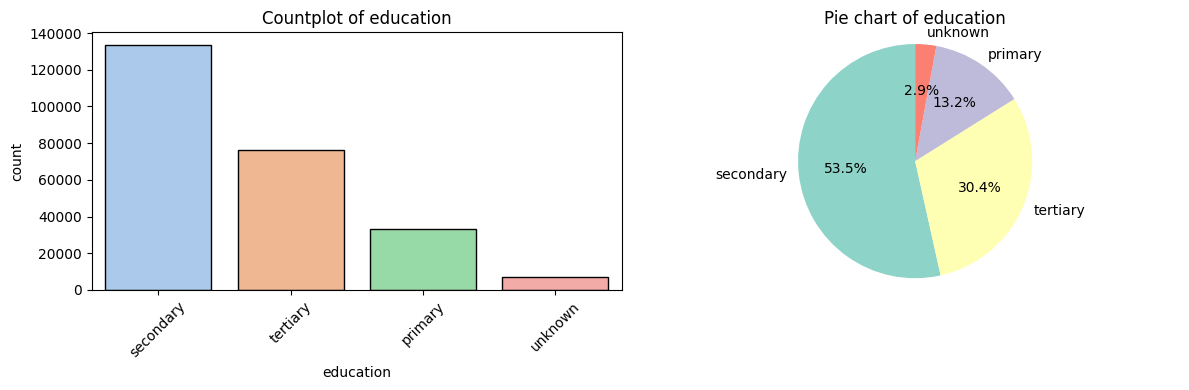

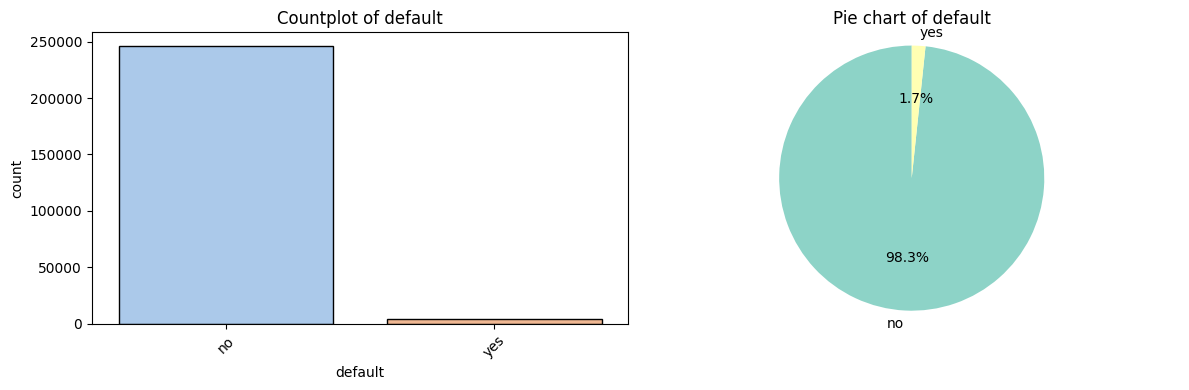

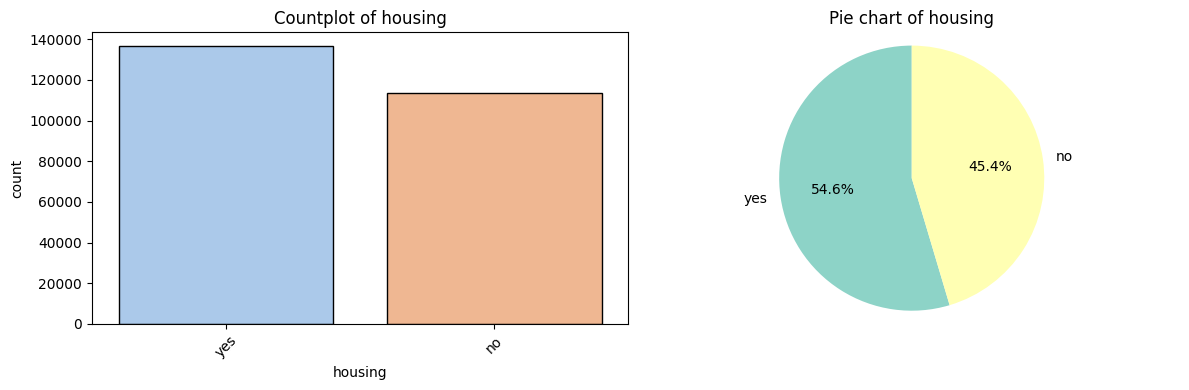

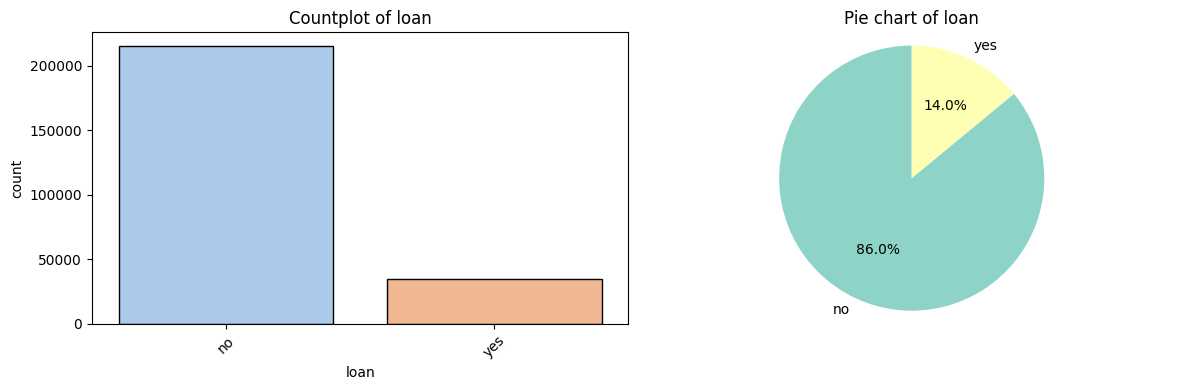

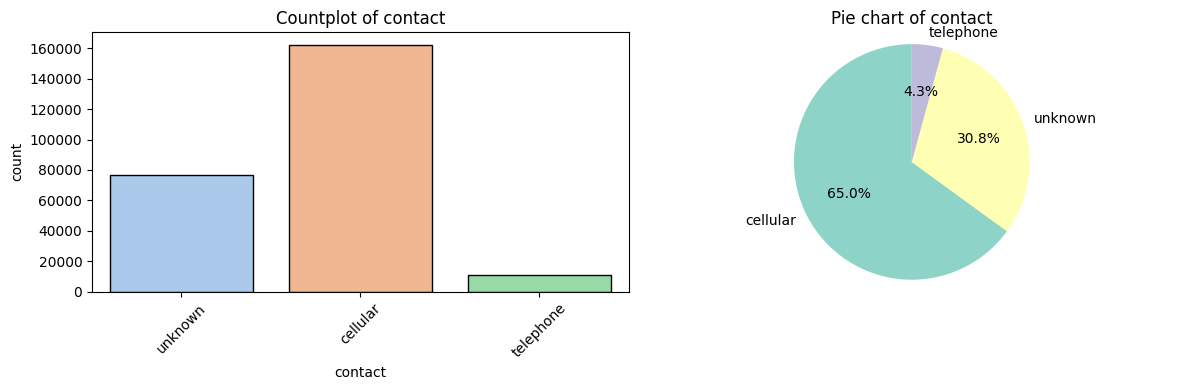

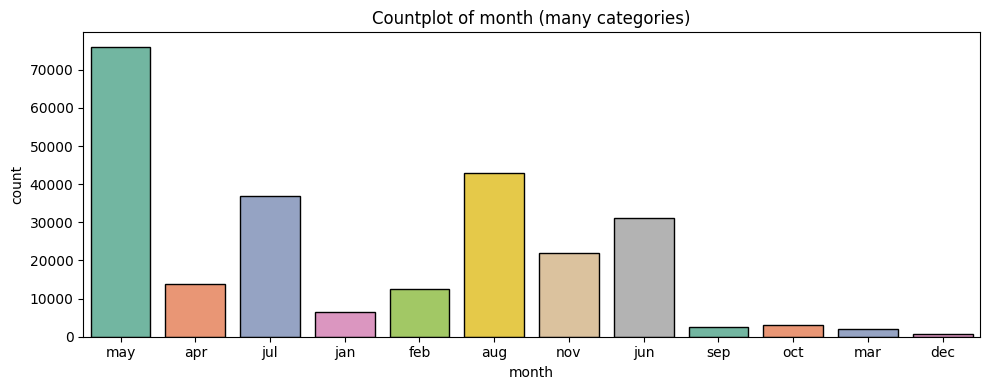

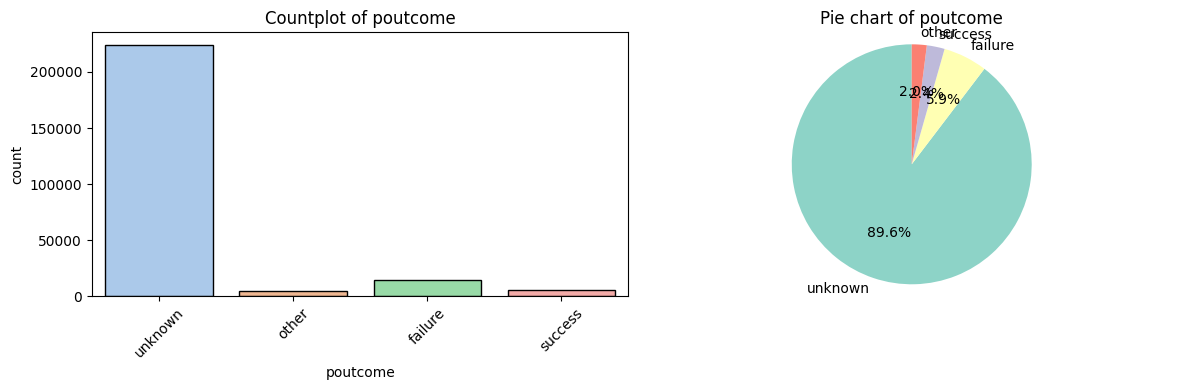

In [52]:
visual_categorical_plots(df,cat_cols)

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250000.0,874999.500000,72168.927986,750000.0,812499.75,874999.5,937499.25,999999.0
age,250000.0,40.932332,10.081613,18.0,33.00,39.0,48.00,95.0
balance,250000.0,1197.426352,2741.520699,-8019.0,0.00,631.0,1389.00,98517.0
day,250000.0,16.116068,8.258509,1.0,9.00,17.0,21.00,31.0
duration,250000.0,255.342260,271.404326,3.0,91.00,133.0,353.00,4918.0
campaign,250000.0,2.573548,2.709661,1.0,1.00,2.0,3.00,58.0
pdays,250000.0,22.280028,76.915879,-1.0,-1.00,-1.0,-1.00,871.0
previous,250000.0,0.303728,1.384574,0.0,0.00,0.0,0.00,150.0


In [54]:
def visula_numcol(df,num_cols):
   for col in num_cols:
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='#1f77b4')
        plt.title(f'Histogram of {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='#ff7f0e')
        plt.title(f'Boxplot of {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.xticks(fontsize=10)

        plt.tight_layout(pad=3.0)
        plt.show()

# **clean data**

In [55]:
df=df.replace('unknown',np.nan)

In [56]:
df.isna().sum().reset_index().rename(columns={'index':'column',0:'missing_values'}).sort_values(by='missing_values',ascending=False)

,column,missing_values
16,poutcome,224115
9,contact,76896
4,education,7250
2,job,1022
0,id,0
5,default,0
6,balance,0
1,age,0
3,marital,0
8,loan,0


In [57]:
import pandas as pd

def handle_missing_values(df: pd.DataFrame, threshold=0.40):
    df = df.copy()
    report_records = []

    for col in df.columns:
        missing_ratio = df[col].isna().mean()

        if missing_ratio == 0:
            report_records.append([col, "No missing values", f"{missing_ratio:.2%}"])
            continue

        elif missing_ratio <= threshold:
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].fillna(df[col].mean())
                action = "Filled with mean"
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
                action = "Filled with mode"
            report_records.append([col, action, f"{missing_ratio:.2%}"])

        else:  # missing_ratio > threshold
            df = df.drop(columns=[col])
            report_records.append([col, "Dropped column", f"{missing_ratio:.2%}"])

    report_df = pd.DataFrame(report_records, columns=["Column", "Action", "Missing Ratio"])
    return df, report_df


In [58]:
df,report=handle_missing_values(df)
report

,Column,Action,Missing Ratio
0,id,No missing values,0.00%
1,age,No missing values,0.00%
2,job,Filled with mode,0.41%
3,marital,No missing values,0.00%
4,education,Filled with mode,2.90%
5,default,No missing values,0.00%
6,balance,No missing values,0.00%
7,housing,No missing values,0.00%
8,loan,No missing values,0.00%
9,contact,Filled with mode,30.76%


In [59]:
df.drop_duplicates(inplace=True)

In [60]:
print(f"number of duplicated rows: {df.duplicated().sum()}")

number of duplicated rows: 0


In [61]:
df.drop(columns=['balance','pdays','previous','campaign'],inplace=True)

In [62]:
num_cols=df.select_dtypes(include=['int64','float64']).columns

In [63]:
num_cols

Index(['id', 'age', 'day', 'duration'], dtype='object')

In [64]:
def handle_outlier(df, num_cols, strategy='replace', target_col='y'):
    outlier_report = []

    for col in num_cols:
        if col == target_col or not np.issubdtype(df[col].dtype, np.number):
            continue  

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        n_outliers = outliers.shape[0]

        outlier_report.append({
            'column': col,
            'outliers_found': n_outliers,
            'lower_bound': lower,
            'upper_bound': upper
        })

        if n_outliers > 0:
            if strategy == 'replace':
                median = df[col].median()
                df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])
            elif strategy == 'remove':
                df.drop(outliers.index, inplace=True)

    report_df = pd.DataFrame(outlier_report)
    return report_df

In [65]:
report=handle_outlier(df,num_cols)
report

,column,outliers_found,lower_bound,upper_bound
0,id,0,625000.5,1124998.5
1,age,1637,10.5,70.5
2,day,0,-9.0,39.0
3,duration,16531,-302.0,746.0


# **preproccing**

In [66]:
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(include=['int64','float64']).columns

In [67]:
for col in cat_cols:
  print(f"{col}: {df[col].unique()}")

job: ['blue-collar' 'management' 'self-employed' 'technician' 'services'
 'retired' 'entrepreneur' 'admin.' 'housemaid' 'unemployed' 'student']
marital: ['married' 'single' 'divorced']
education: ['secondary' 'tertiary' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['cellular' 'telephone']
month: ['may' 'apr' 'jul' 'jan' 'feb' 'aug' 'nov' 'jun' 'sep' 'oct' 'mar' 'dec']


In [68]:
binary_cols = ["default", "housing", "loan", "contact"]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [69]:
edu_mapping = [["primary", "secondary", "tertiary"]]  

oe = OrdinalEncoder(categories=edu_mapping)
df[["education"]] = oe.fit_transform(df[["education"]])

In [70]:
month_map = {
    'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
    'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12
}

df["month_num"] = df["month"].map(month_map)

df["month_sin"] = np.sin(2 * np.pi * df["month_num"]/12)
df["month_cos"] = np.cos(2 * np.pi * df["month_num"]/12)


df.drop(columns=["month", "month_num"], inplace=True)

# **Split Data**

In [71]:
X = df.drop(columns=['id', 'duration'])

In [75]:
import joblib
preprocessor = joblib.load("/kaggle/working/preprocessor.pkl")
X_test_transformed = preprocessor.transform(X)

In [76]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/best_nn.h5")

I0000 00:00:1758211936.012407    1207 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
y_pred = model.predict(X_test_transformed)
y_pred = (y_pred > 0.5).astype(int).flatten()

I0000 00:00:1758211940.094958    1302 service.cc:148] XLA service 0x781c08005fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758211940.095008    1302 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758211940.128747    1302 cuda_dnn.cc:529] Loaded cuDNN version 90300


 116/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step  

I0000 00:00:1758211940.319968    1302 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [ ]:
submission = pd.DataFrame({
    "id": df["id"],
    "y": y_pred
})
submission.to_csv("submission.csv", index=False)
print("submission.csv saved")

In [ ]:
#import joblib
preprocessor = joblib.load("/kaggle/working/best_nn.h5")
X_test_transformed = preprocessor.transform(X_test)